# Analyzing Time-series Data with FTGPs

We use time-series decomposition to try to explain/analyze the quality of our FTGPs. Time-series decomposition helps us break down a time-series dataset into three main components:

**1. Trend:** The trend component represents the long-term movement in the data, representing the underlying pattern.

**2. Seasonality:** The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.

**3. Residual (Noise):** The residual component represents random variability that remains after removing the trend and seasonality.

By separating these components, we can gain insights into the behavior of the data and make better forecasts. 

## Types of Time Series Decomposition Techniques

### a) Additive Decomposition

* In additive decomposition, the time series is expressed as the sum of its components. It’s suitable when the magnitude of seasonality doesn’t vary with the magnitude of the time series.

$$Y(t) = Trend(t) + Seasonal(t) + Residual(t)$$

### b) Multiplicative Decomposition

* In multiplicative decomposition, the time series is expressed as the product of its components.It’s suitable when the magnitude of seasonality scales with the magnitude of the time series.

$$Y(t) = Trend(t) * Seasonal(t) * Residual(t)$$

## Methods of Decomposition
### a) Moving Averages

* Moving averages involve calculating the average of a certain number of past data points. It helps smooth out fluctuations and highlight trends.

### b) Seasonal Decomposition of Time Series

* The Seasonal and Trend decomposition using Loess (STL) is a popular method for decomposition, which uses a combination of local regression (Loess) to extract the trend and seasonality components.

### c) Exponential Smoothing State Space Model

* This method involves using the ETS framework to estimate the trend and seasonal components in a time series.

## Reference
* https://www.geeksforgeeks.org/time-series-decomposition-techniques/


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

## Import from local directory
import sys

sys.path.insert(0, '../src')
from TemporalGP.TGP.tgrad_ami import TGradAMI
from TemporalGP.TGP.t_graank import TGrad

In [9]:
# Hyperparameters

f_path = "../datasets/air_quality1k.csv"
eq = False
min_sup = 0.5
tgt_col = 2
min_rep = 0.5
num_cores = 4

In [3]:
data = pd.read_csv(f_path)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [10]:
tgp = TGradAMI(f_path, eq, min_sup, tgt_col, min_rep, num_cores)
# tgp.full_attr_data

Dataset Ok


In [3]:
list_tgp = []  #tgp.discover_tgp(parallel=True)


In [13]:
output_txt = ""
for txt in tgp.titles:
    col = int(txt[0])
    if col == tgt_col:
        output_txt += (str(txt[0]) + '. ' + str(txt[1].decode()) + '**' + '\n')
    else:
        output_txt += (str(txt[0]) + '. ' + str(txt[1].decode()) + '\n')

count = 0
if isinstance(tgp, TGradAMI):
    if list_tgp:
        count = len(list_tgp)
        for tgp in list_tgp:
            output_txt += f"{tgp.to_string()} :  {tgp.support}\n"
else:
    for obj in list_tgp:
        if obj:
            for tgp in obj:
                count += 1
                # output_txt += (str(tgp.to_string()) + ' : ' + str(tgp.support) +
                #               ' | ' + str(tgp.time_lag.to_string()) + '\n')
                output_txt += f"{tgp.to_string()} :  {tgp.support}\n"

print(output_txt)

0. Date
1. Time
2. CO(GT)**
3. PT08.S1(CO)
4. NMHC(GT)
5. C6H6(GT)
6. PT08.S2(NMHC)
7. NOx(GT)
8. PT08.S3(NOx)
9. NO2(GT)
10. PT08.S4(NO2)
11. PT08.S5(O3)
12. T
13. RH
14. AH
['2-', ['(12+) +2.0 days']] :  0.567
['2-', ['(13+) -1 seconds']] :  0.581
['2-', ['(14-) +24.0 hours']] :  0.502
['2-', ['(4-) +1.0 hours'], ['(7-) +1.0 hours'], ['(3-) +1.0 hours']] :  0.501
['2-', ['(4-) +1.0 hours'], ['(8+) +1.0 hours'], ['(11-) +1.0 hours']] :  0.503
['2-', ['(4-) +1.0 hours'], ['(11-) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.509
['2-', ['(4-) +1.0 hours'], ['(8+) +1.0 hours'], ['(3-) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.501
['2-', ['(4-) +1.0 hours'], ['(7-) +1.0 hours'], ['(10-) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.502
['2-', ['(4-) +1.0 hours'], ['(8+) +1.0 hours'], ['(10-) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.512
['2-', ['(9-) +1.0 hours'], ['(4-) +1.0 hours'], ['(7-) +1.0 hours'], ['(8+) +1.0 hour

In [ ]:
prev_res = ("\
0. Date \
1. Time\
2. CO(GT)**\
3. PT08.S1(CO)\
4. NMHC(GT)\
5. C6H6(GT)\
6. PT08.S2(NMHC)\
7. NOx(GT)\
8. PT08.S3(NOx)\
9. NO2(GT)\
10. PT08.S4(NO2)\
11. PT08.S5(O3)\
12. T\
13. RH\
14. AH\
['2-', ['(12+) +2.0 days']] :  0.567\
['2-', ['(13+) -1 seconds']] :  0.581\
['2-', ['(14-) +24.0 hours']] :  0.502\
['2-', ['(4-) +1.0 hours'], ['(7-) +1.0 hours'], ['(3-) +1.0 hours']] :  0.501\
['2-', ['(4-) +1.0 hours'], ['(8+) +1.0 hours'], ['(11-) +1.0 hours']] :  0.503\
['2-', ['(4-) +1.0 hours'], ['(11-) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.509\
['2-', ['(4-) +1.0 hours'], ['(8+) +1.0 hours'], ['(3-) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.501\
['2-', ['(4-) +1.0 hours'], ['(7-) +1.0 hours'], ['(10-) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.502\
['2-', ['(4-) +1.0 hours'], ['(8+) +1.0 hours'], ['(10-) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.512\
['2-', ['(9-) +1.0 hours'], ['(4-) +1.0 hours'], ['(7-) +1.0 hours'], ['(8+) +1.0 hours'], ['(5-) +1.0 hours'], ['(6-) +1.0 hours']] :  0.503")

prev_res

In [7]:
new_data = tgp.process_time()
data_df = pd.DataFrame(data=new_data[1:, :], columns=new_data[0, :])
data_df

,Timestamp,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2808388800.0,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2808392400.0,2,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2808396000.0,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2808399600.0,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2808403200.0,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,2813018400.0,4.7,1597,-200,26.5,1466,320,518,109,2400,1687,16.9,66.1,1.2613
1287,2813022000.0,3.4,1483,-200,17.4,1222,318,597,109,2054,1529,17.4,68.9,1.3557
1288,2813025600.0,2.5,1222,-200,12.9,1080,201,742,111,1755,1366,21.4,45.0,1.1291
1289,2813029200.0,2,1060,-200,10.9,1010,135,858,102,1623,1074,23.9,30.7,0.9002


In [30]:
datetime_series = pd.to_datetime(new_data[1:, 0].astype(float), unit='s')
datetime_index = pd.DatetimeIndex(datetime_series, freq='h')
datetime_index

DatetimeIndex(['2058-12-29 12:00:00', '2058-12-29 13:00:00',
               '2058-12-29 14:00:00', '2058-12-29 15:00:00',
               '2058-12-29 16:00:00', '2058-12-29 17:00:00',
               '2058-12-29 18:00:00', '2058-12-29 19:00:00',
               '2058-12-29 20:00:00', '2058-12-29 21:00:00',
               ...
               '2059-02-20 21:00:00', '2059-02-20 22:00:00',
               '2059-02-20 23:00:00', '2059-02-21 00:00:00',
               '2059-02-21 01:00:00', '2059-02-21 02:00:00',
               '2059-02-21 03:00:00', '2059-02-21 04:00:00',
               '2059-02-21 05:00:00', '2059-02-21 06:00:00'],
              dtype='datetime64[ns]', length=1291, freq='h')

In [40]:
ts_1 = pd.Series(new_data[1:, 1], index=datetime_index)  # CO(GT)
ts_2 = pd.Series(new_data[1:, 3], index=datetime_index)  # NMHC(GT)
ts_3 = pd.Series(new_data[1:, 7], index=datetime_index)  # PT08.S3(NOx)
ts_4 = pd.Series(new_data[1:, 8], index=datetime_index)  # NO2(GT)

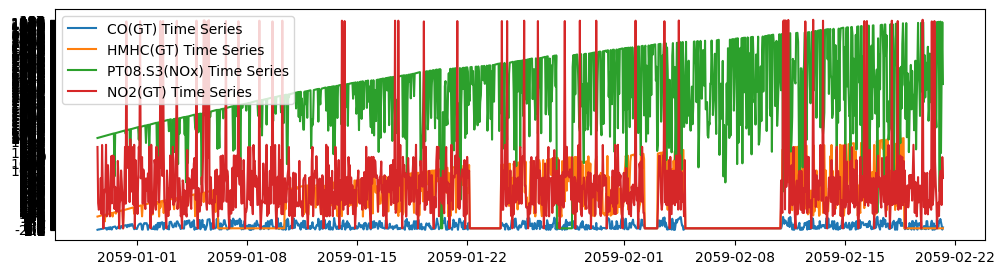

In [41]:

plt.figure(figsize=(12, 3))
plt.plot(ts_1, label='CO(GT) Time Series')
plt.plot(ts_2, label='HMHC(GT) Time Series')
plt.plot(ts_3, label='PT08.S3(NOx) Time Series')
plt.plot(ts_4, label='NO2(GT) Time Series')
plt.legend()

In [42]:
# Decompose time-series
result_add1 = seasonal_decompose(ts_1, model='additive')
result_add2 = seasonal_decompose(ts_2, model='additive')
result_add3 = seasonal_decompose(ts_3, model='additive')
result_add4 = seasonal_decompose(ts_4, model='additive')


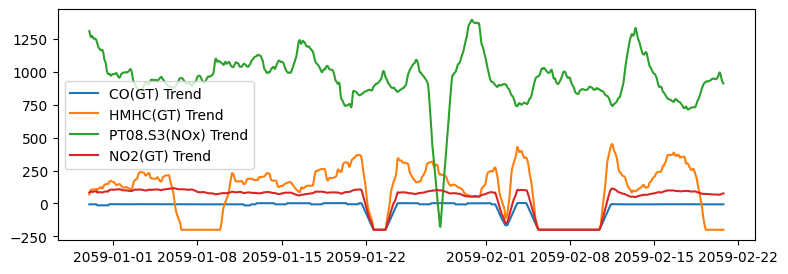

In [43]:
# Plotting 'Trend' Component

plt.figure(figsize=(9, 3))
plt.plot(result_add1.trend, label='CO(GT) Trend')
plt.plot(result_add2.trend, label='HMHC(GT) Trend')
plt.plot(result_add3.trend, label='PT08.S3(NOx) Trend')
plt.plot(result_add4.trend, label='NO2(GT) Trend')
plt.legend()

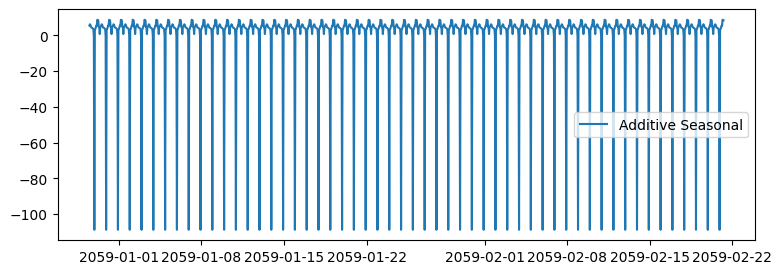

In [35]:
# Plotting 'Seasonal' Component

plt.figure(figsize=(9, 3))
plt.plot(result_add1.seasonal, label='Additive Seasonal')
plt.legend()

In [1]:
# Calculating the Simple Moving Average (SMA)
   
sma_window = 8  # 8-hour moving average
sma1 = ts_1.rolling(window=sma_window).mean()
sma2 = ts_2.rolling(window=sma_window).mean()
sma3 = ts_3.rolling(window=sma_window).mean()
sma4 = ts_4.rolling(window=sma_window).mean()
#sma1

NameError: name 'ts_1' is not defined

In [2]:
# Calculating the Exponential Moving Average (EMA)

ema_window = 24  # 24-hour moving average
ema1 = ts_1.ewm(span=ema_window, adjust=False).mean()
ema2 = ts_2.ewm(span=ema_window, adjust=False).mean()
ema3 = ts_3.ewm(span=ema_window, adjust=False).mean()
ema4 = ts_4.ewm(span=ema_window, adjust=False).mean()
#ema1


NameError: name 'ts_1' is not defined

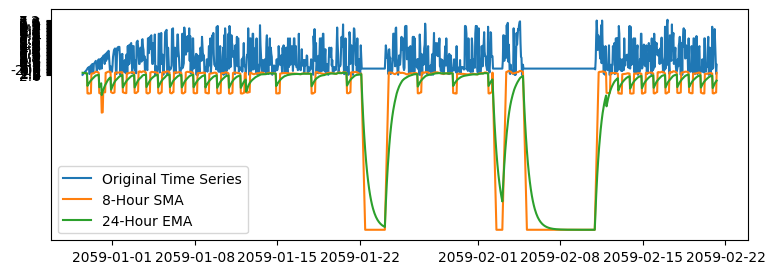

In [66]:
# Plotting the Moving Averages

plt.figure(figsize=(9, 3))
plt.plot(ts_1, label='Original Time Series')
plt.plot(sma1, label=f'{sma_window}-Hour SMA')
plt.plot(ema1, label=f'{ema_window}-Hour EMA')
plt.legend()